In [681]:
import math
import warnings
import datetime 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from pandas_datareader import DataReader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras.backend as K
from sklearn import metrics
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.models import load_model
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from keras.layers import Dropout
warnings.filterwarnings("ignore")

In [682]:
def get_model():

  model_input = Input(shape=(x_train.shape[1], 2))
  x = LSTM(160, return_sequences=True)(model_input)
  # x = Dropout(0.2)(x)
  score_first_part = Dense(160, use_bias=False)(x)
  h_t = Lambda(lambda x: x[:, -1, :], output_shape=(160,))(x)
  score = Dot(axes=[1, 2])([h_t, score_first_part])
  attention_weights = Activation('softmax')(score)
  context_vector = Dot(axes=[1, 1])([x, attention_weights])
  pre_activation = Concatenate()([context_vector, h_t])
  attention_vector = Dense(128, use_bias=False, activation='tanh')(pre_activation)
  x = keras.layers.Reshape((1,128))(attention_vector)

  x = LSTM(256,return_sequences=False)(x)
  x = Dense(96)(attention_vector)
  model_ouput = Dense(1)(x)
  model = Model(model_input, model_ouput)

  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
  es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10)
  mc = ModelCheckpoint('check.h5', monitor='val_mae', mode='min', verbose=1, save_best_only=True)

  return model , es, mc

In [683]:
def mape(Close_prices, pred_prices):
    real = np.array(Close_prices)
    predict =  np.array(pred_prices)
    return np.mean(np.abs((real-predict)/real))*100

def get_min_max(data_train,col):
  min = data_train.min(axis =0)[col]
  max = data_train.max(axis =0)[col]
  return min, max

def scale(data_scale, data_train, col):
  min, max = get_min_max(data_train,col)
  output = (data_scale-min)/(max-min)
  return output

def inv_scale(data_scale, data_train, col):
  min, max = get_min_max(data_train,col)
  output = data_scale*(max-min)+min
  return output

def fit_scale(data_scale0, data_train, col):
   output = np.transpose(np.array([data_scale0.apply(lambda data_scale0: scale(data_scale0, data_train, col))]))
   return output

def get_prediction(x_test, data_train, col):
  predictions = model.predict(x_test)
  predict_data = inv_scale(predictions,data_train,col)
  return predict_data

def get_real(data_test, predict_data):
  real = data_test[day:]
  real['Predictions'] = predict_data
  return real

def predict_next_day(dataset, data_train,col):
  last = dataset[-day:]
  last_scaled = getcheck(last,data_train,col)
  test = []
  test.append(last_scaled)
  test = np.array(test)
  test = np.reshape(test, (test.shape[0], test.shape[1],2))
  pred = model.predict(test)
  pred = inv_scale(pred,data_train,col)
  return pred[0][0]

def Result(real):
  Close_prices = real.Price.tolist()
  pred_prices = real.Predictions.tolist()
  mse_v = mean_squared_error(Close_prices, pred_prices)
  rmse_v = math.sqrt(mse_v)
  r2 = r2_score(Close_prices, pred_prices)
  mape_v =mape(Close_prices, pred_prices)
  result = {'MAPE':round(mape_v,3),'RMSE': round(rmse_v,3),'MSE': round(mse_v,3), ' R^2':round(r2,3)}
  return result

def getcheck(price,data_train,col):
  scaled_data_train = fit_scale(price['Price'], data_train, col)
  std = np.std(fit_scale(data_train['Price'], data_train, col))
  data = (price['Check4'].to_numpy().reshape(-1,1)-np.ones(scaled_data_train.shape)*np.mean(scaled_data_train))/std
  data = (data-data.min())/(data.max()-data.min())
  data_std =  np.append(scaled_data_train,data.reshape(-1,1),axis=1)
  return data_std

In [684]:
day = 45
df = pd.read_excel('/content/new.xlsx')
data = df 
train_data_len = 1600
dataset = data[['Price','Check4']]
data_train = dataset[:train_data_len]
data_test = dataset[(train_data_len-day):1800]

Scale

In [685]:
scaled_data_train = getcheck(data_train, data_train, 0)
scaled_data_test =  getcheck(data_test, data_train, 0)

Data Train

In [686]:
x_train=[]
y_train=[]
for i in range(day,train_data_len):
  x_train.append(scaled_data_train[i-day:i])
  y_train.append(scaled_data_train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 2))

Data Test

In [687]:
test_data = scaled_data_test
x_test = []
y_test = scaled_data_test[day:,:]
for i in range(day,len(test_data)):
  x_test.append(test_data[i-day:i])


x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 2))

Model

In [688]:
model, es, mc = get_model()
H = model.fit(x_train, y_train, batch_size=32, epochs=300, validation_data=(x_test,y_test), verbose= 1, callbacks=[es,mc]) #, callbacks=[es,mc]

Epoch 1/300
48/48 [==============================] - 2s 15ms/step - loss: 0.0089 - mae: 0.0582 - val_loss: 0.0282 - val_mae: 0.0995

Epoch 00001: val_mae improved from inf to 0.09946, saving model to check.h5
Epoch 2/300
48/48 [==============================] - 0s 7ms/step - loss: 0.0021 - mae: 0.0302 - val_loss: 0.0286 - val_mae: 0.0969

Epoch 00002: val_mae improved from 0.09946 to 0.09693, saving model to check.h5
Epoch 3/300
48/48 [==============================] - 0s 7ms/step - loss: 0.0018 - mae: 0.0279 - val_loss: 0.0286 - val_mae: 0.0962

Epoch 00003: val_mae improved from 0.09693 to 0.09620, saving model to check.h5
Epoch 4/300
48/48 [==============================] - 0s 7ms/step - loss: 0.0018 - mae: 0.0287 - val_loss: 0.0292 - val_mae: 0.1002

Epoch 00004: val_mae did not improve from 0.09620
Epoch 5/300
48/48 [==============================] - 0s 6ms/step - loss: 0.0016 - mae: 0.0271 - val_loss: 0.0284 - val_mae: 0.0944

Epoch 00005: val_mae improved from 0.09620 to 0.09442

In [690]:
model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 45, 2)]      0                                            
__________________________________________________________________________________________________
lstm_66 (LSTM)                  (None, 45, 160)      104320      input_34[0][0]                   
__________________________________________________________________________________________________
lambda_33 (Lambda)              (None, 160)          0           lstm_66[0][0]                    
__________________________________________________________________________________________________
dense_132 (Dense)               (None, 45, 160)      25600       lstm_66[0][0]                    
___________________________________________________________________________________________

In [691]:
model = keras.models.load_model("check.h5")

Predict

In [692]:
predict_data0 = get_prediction(x_test,data_train,0)

Plot

In [693]:
train = dataset[:train_data_len+day]

real0 = get_real(data_test, predict_data0)

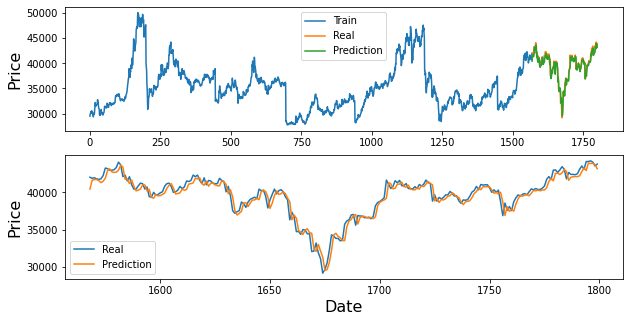

In [694]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
# plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.plot(train['Price'])
plt.plot(real0[['Price','Predictions']])
plt.legend(['Train','Real','Prediction'],loc='best')

plt.subplot(2,1,2)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.plot(real0[['Price','Predictions']])
plt.legend(['Real','Prediction'],loc='best')
plt.show()

In [702]:
R = Result(real0)
print('Model test: ',R)

Model test:  {'MAPE': 1.338, 'RMSE': 730.754, 'MSE': 534001.4085, ' R^2': 0.933}


Next_day

In [696]:
pre = predict_next_day(data_test, data_train, 0)
print('Next day:',pre)


Next day: 43293.06


#Train error

In [697]:
predict = get_prediction(x_train,data_train,0)

In [698]:
real_train = get_real(data_train, predict)

In [699]:
R = Result(real_train)
print('Model train: ',R)

Model train:  {'MAPE': 1.208, 'RMSE': 700.151, 'MSE': 490211.78, ' R^2': 0.975}
